In [1]:
#Name - Pavan Chowdary Cherukuri
#NetID - pc3088
#The pendulum.py was copied into this to run the file easily as asked
# a few packages we need to import

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

NUMBER_STATES = 2
NUMBER_CONTROLS = 1

MAX_VELOCITY = 6.

DELTA_T = 0.1

## internal constants - DO NOT USE
_INTERNAL_DT = 0.01
_INTEGRATION_RATIO = 10
_GRAVITY = 9.81


def get_next_state(x,u):
    """
    This function integrates the pendulum for one step of DELTA_T seconds

    Inputs:
    x: state of the pendulum (theta,omega) as a 2D numpy array
    u: control as a scalar

    Output:
    the state of the pendulum as a 2D numpy array at the end of the integration
    """
    x_next = x[0]
    v_next = x[1]
    for i in range(_INTEGRATION_RATIO):
        xx_next = (x_next + _INTERNAL_DT * v_next)%(2*np.pi)
        v_next = np.clip(v_next + _INTERNAL_DT * (u-_GRAVITY*np.sin(x_next)-0.2*v_next), -MAX_VELOCITY, MAX_VELOCITY)
        x_next = xx_next
    return np.array([x_next,v_next])


def simulate(x0, policy, T):
    """
    This function simulates the pendulum for T seconds from initial state x0 using a policy (i.e. a function of x). It means that policy is called as policy(x) and returns one control)

    Inputs:
    x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
    policy: a function that get a state as an input and return a scalar
    T: the time to integrate for

    Output:
    x (2D array) and u (1D array) containing the time evolution of states and control
    """
    horizon_length = int(T/DELTA_T)
    x=np.empty([2, horizon_length+1])
    x[:,0] = x0
    u=np.empty([horizon_length])
    t = np.zeros([horizon_length+1])
    for i in range(horizon_length):
        u[i] = policy(x[:,i])
        x[:,i+1] = get_next_state(x[:,i], u[i])
        t[i+1] = t[i] + DELTA_T
    return t, x, u


def animate_robot(x):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """

    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    steps = 1
    use_dt = int(DELTA_T * 1000)
    plotx = x[:,::steps]

    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()

    list_of_lines = []

    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)

    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])

        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])

        return list_of_lines

    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [8]:
import numpy as np
import math

#Number of episodes
episodes=6500
#epsilon value for e-greedy policy
epsilon=0.1
#Learning rate gamma
gamma=0.1
#Discount factor alpha
alpha=0.99
#Discretized theta values excluding the last value which is 2*pi
theta_values=np.linspace(0, 2*np.pi, 50, endpoint=False)
#Values that control can have
u_values=np.array([-4,0,4])
#Discretized omega values
omega_values=np.linspace(-6, 6, 50)
#Number of time steps
timesteps=100

#Get cost function returns the cost value when state and control were given
def get_cost(x,u):
  #theta and omega were extracted from the input state
  theta, omega = x
  #Cost is calculated by the given formula
  cost_value = (theta - np.pi)*(theta - np.pi) + 0.01*omega*omega + 0.0001 * u*u
  return cost_value


def get_policy_and_value_function(q_table):
  
  #The shape of Q-table gives the number of theta, omega and u, basically the number of states and controls
  theta_num, omega_num, u_num = q_table.shape

  #Initializing policy and value matrices
  policy_matrix = np.zeros((theta_num, omega_num), dtype=int)
  value_matrix = np.zeros((theta_num, omega_num))

  #Extracting the minimum index values from the Q table and filling policy and value matrices 
  for i in range(theta_num):
      for j in range(omega_num):
          u_idx = np.argmin(q_table[i, j, :])
          policy_matrix[i, j],value_matrix[i, j] = u_values[u_idx],(q_table[i, j, u_idx])

  return value_matrix,policy_matrix

def dummy_controller(x):
  
  #Gets the indices of theta and omega to extract the index of u
  theta_idx,omega_idx  = np.argmin(np.abs(theta_values - x[0])),np.argmin(np.abs(omega_values - x[1]))

  #The index of optimal control is obtained from the Q-table
  u_index = np.argmin(q_table[theta_idx,omega_idx,:])

  #The optimal u_value is returned
  return u_values[u_index]

def q_learning(q_table):
  
  #Cost_values list to store the costs to keep a track of the progress
  cost_values=[]

  #Looping through the number of episodes
  for episode in range(episodes):

    #Initializing the states to zeros since it starts at rest position
    x = np.zeros((2,),dtype=int)
    x_old_theta=x[0]
    x_old_omega=x[1]
    
    #Extracting indices
    xtheta_idx_min,xomega_idx_min=np.argmin(np.abs(theta_values-x_old_theta)),np.argmin(np.abs(omega_values-x_old_omega))
    
    #Initializing the cost
    cost=0

    #Looping through time steps
    for t in range(timesteps):
      #e-greedy policy
      if np.random.uniform(0,1) < epsilon:
        u = np.random.randint(0, 3)
      else:
        u = np.argmin(q_table[xtheta_idx_min, xomega_idx_min])

      #Finding next states
      x_next = get_next_state(x,u_values[u])
      theta_new=x_next[0]
      omega_new=x_next[1]

      #Extracting indices
      idx_discrete_theta,idx_discrete_omega = np.argmin(np.abs(theta_values - theta_new)),np.argmin(np.abs(omega_values - omega_new))
      
      #Finding the TD error at time t and updating the Q values
      delta= get_cost(x,u_values[u]) + alpha*np.min(q_table[idx_discrete_theta, idx_discrete_omega,:]) - q_table[xtheta_idx_min, xomega_idx_min, u]
      q_table[xtheta_idx_min, xomega_idx_min, u] = q_table[xtheta_idx_min,xomega_idx_min , u] + gamma*delta

      #Reinitializing the state and index values for next time step
      x = x_next
      xtheta_idx_min,xomega_idx_min=idx_discrete_theta,idx_discrete_omega 
      cost+=get_cost(x,u_values[u])
    
    cost_values.append(cost)


  return q_table,cost_values

In [9]:
q_table=np.zeros((50,50,3))
q_t,cost_to_plot=q_learning(q_table)
T = 10.
x0 = np.array([0,0.])
t, x, u = simulate(x0, dummy_controller, T)

In [10]:
animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABbvW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAn0ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMADN2InuDwrXQ9FeAAICAAUTkeZCngr+AB
s+FTpEmHxPfww3BGSVzNCQT4FB6nH/jCVfIK24/+f/sObypPxVLtkvXkpxYMcSloRE2S9vN4tz0h
Y9q7W7gmR/UoVKHYqcSUeZmlC1Dq3/tVcsOy6TG7H0aodJBeENYg+04aJDbCZsw+g+JY+6aDooIc
PxSvlsc/agbbFcWDtLJy4ciAARbxLkRSsMMGeJgPpeZAnHtIb0+XK+mc/451KNd0D/4V+PvKN9zA
dawAnmLhrMJ5zBhSWEgIN2KQlhMPpFZjiIzda89V0krbvtdoq6FH4pLTRjidxcobXbiUAdkjnk2t
n23rCp2JwWaMra9i67bqhcNK3SD/qNpNpPTtFTf+y2PmURZOqy7xS9FbrnbTm8FDXyFyToyCks/5
KlJjqXIEX6LOqaWBV2CzwQ21fTEL81qAmPguLG8nKoH+2XEgNJTP/yhQH3chXoX/EwFW18KcxUcE
fcH3mvMB6QVqWL5f25w3bQNFHH531nPg/behJtlb/VVRUcdugHzHUmADZAAIZpdzbwY/VqSWz1bh
lYbg2FKg+OM5JI/BxICm/oZ94yIWhx+WQc25tzPR4ng9DB6P7kWH95OFezmHqocAOZIu+ZmYtMt+
GpoIGdJSvLtxzFkkQgK9qXPiUWQzFqT7e3WxICipwcIFPYAc/0c67+AzxskPg+erqTM0YTnB5gIm
W/5jXFgBw03QqqZoTM3zgKubCMwto25h6ilNtfBj5EwBE22gGSMHC4LvAID6KH0v7HRS/Q68jw86
iaHl5QmqIxNdmgNG796B8BhDVa4A+pqj93jpKw/G6sQoOEdex3UF2WfkSd9ryD+V6CgCBb57C3AA
BOHb0gAAAwAXOVOOLFDShyrqUs2+VwpQTveUWpVyWP5Kw1vpkgemI/BrgTbQLKCtX7FXzrFJrtQm
B3wYTv6FDpQxYL/MzjfJir/kmY0OZnBgtalapgncjP1Lm3EleT6y7kgATXfPwBeP7XBPWzKpfTh1
208QEisv/qxMRkkTfv9GWpiCwfOpExblglmFiWogtXxUtgynzhN1xIhG/1mpH3YtEqBJ4oextY/n
a9uYoFfLANjenYzY5ZKb9Q309qW0K8x958aflRub/Z4CTDD6/QzcL5LkKVODlJl3/afRU2fXWb7B
xHRqEgGPCphRxpq3TJ0t7yCJ/t0xh12oU6UK9TFPhumesuoFTh/6856ZtJlKe1gAw6MZb3NaaNIY
X/No/MwvyoqppCHXqXGG9Spbw17hbRp2beOq2RTiYWCQPhUACciAAAARAzye/tnAJPpO6qzOQpvj
XzPiy2+zqjzXLnMmRq+pWAHl8ScMd3ED5nZDn4f8HReV9c3+bB7ZUs3QpBoSHTV+YRQg8VE7SMvb
xWpPx0I6bbmD0JtYmNzTGWE4QnNnDYPJDrTRBr8s76XRczGRfLR3ldp6sphFwS4ewhZ4khsT02cv
Eg/8INOqUQkavu8AFas1So4nhPbyKuP+AgBJLzX9xl6lN7+FlXodkt6oiMt/6+Vo0rjX5FXWcO6Y
X227CXQ2cqf7sFQ8L72TLmDBNYa6dHXtOorSBIe1pUhm19ctCl6hTlqQ8esIuFUezXxmxJrZP/+V
o/qhsP9I2tDNbyTFPRi9sA428PMn6+wKoNIvQ5HwtKveqVJJbh/JwSkct3E3B+c3kYDFM+bg714h
IA7EhgTfWLZpctwJSRD/gAADgyPf1YSVo35UPvnLVlUs6g24N34RHR5YEtrNmXgiQXvhzk/zs7fE
VOcmPRWKAZu/H8P/nMdNF6ntG9t6xjHvy8WH0q9hX5X9vcuoJSVMa90D+1OEzD+wtzfZL6jx1oE6
zaPaU13QVl9hSWUdeYtu0gH49Ox0ehvglwri4tc1rcK+c1lgSeXsTTBcH+QB0KvDQn3BpxUe72n5
5JpL+g7LfcM06E+5EpX9joZOEsse8z+YZFoor5or6aZhaPWkEbbyCJUTONIfx2DRXMmMsHbd+3Cj
/LxQV4pZoKirRrteo1Gt8ihX9VytxrWMq4fMsweqncRcn2xZW25aEH8zNJWKDqFvm6oChSvTnrSU
Xe7R47shf6FikzwiwdY8+roMcpqQ+K5eAoamLrRo8QCY+a8JlC/fykN+rf803LOODgCxXqgFdE19
xsthedskmAbNymIAAAQkIAIvNqFdrOEUNdiisqpJlMP0kVtLPGzAU/PHpoRfY5q7OC36KZElQNUW
KvNEcXvhSFx7IN0LTkSNWB8WAwhixrRgXic3KaXsGvVuwzw5rEu/yzSR+fFcCbiQ8s7uqcThxsVK
1Lfr5Zb6npilduAzHTk77z2vmL4RnDVC0G9IFsexU3xqZosunnZQOx5nAD5gqBIyUSk5ARD6nMxq
aeNg5oUqKQexfVQvqjuByrO75QNtYUqNEJyT6k1+0CQO2ZVcw+90IqJ3Yz8OOESd1JF7C9ZV4gT6
zVZhdc2UB4XUTszMfhs2ksDA6jvo9ehCr7t8/mCl98fXqiAPemehAqr07XKjPpDatZayKEGfQs4v
P17K5tLYUTytKojFMqwgCOIVRhdusS0ESaqzeU4PenpFILnrZSAQuQoRbrg2BKLa+y+3oHP9rbLL
t9cfOQnqsXu1kxCtRIrX0NdIuZGb7cxpDmi0GfGhZdGJWiUnWj+EICYSeuFk+9z+aFaPsaEYUY5m
qboQzMJKN3ewLJnbYpcBM98+Gu03UJymG2S7WqlnTQNhJKTe3TVGUzSv1XkdSS2x8Ys41uS2+156
TJp7lercIeaXKajP83azpBiPuy5W5WR79G6K66UfNzqNgXL1+EZ+t4V8ah7qSFu0TzLW0FUjHJdb
XyRisvt/JvQv9iLEUPR5p

Text(0.5, 0, 'Time [s]')

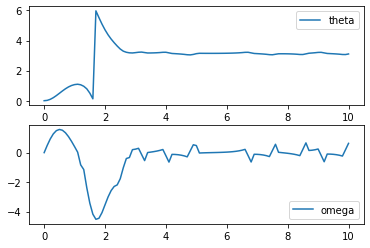

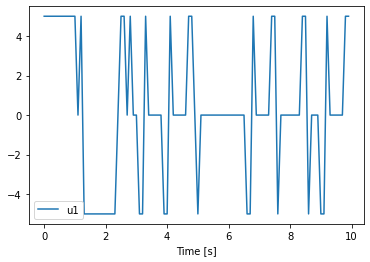

In [11]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

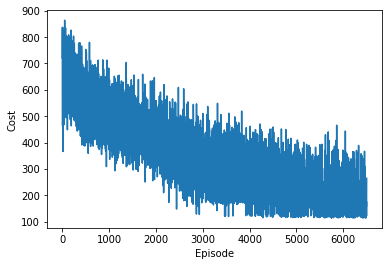

In [12]:
plt.plot(cost_to_plot)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.show()

Text(0.5, 1.0, 'Policy')

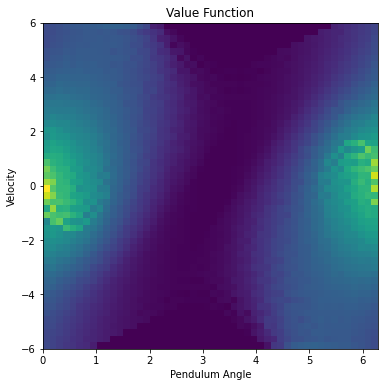

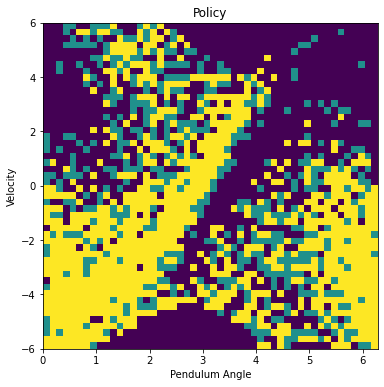

In [13]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2
value_fun,policy_fun=get_policy_and_value_function(q_table=q_t)

value_function = value_fun.transpose()
policy = policy_fun.transpose()

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')